# CSC 487 – GeoGuessr Bot: Dataset EDA
Taran Singh & Hannah Moshtaghi
Date: Nov 2025

In [ ]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from PIL import Image
import numpy as np
from collections import Counter
import hashlib
import os
import kagglehub
import zipfile
from pathlib import Path
from tqdm.auto import tqdm

In [ ]:
# get dataset
root = Path(kagglehub.dataset_download("ubitquitin/geolocation-geoguessr-images-50k"))
DATA_ROOT = root / "compressed_dataset"

print("DATA_ROOT:", DATA_ROOT)

# initalize
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

In [ ]:
# build a master dataframe with data about each entry in the dataset

rows = []
country_paths = [p for p in DATA_ROOT.iterdir() if p.is_dir()]
for country_path in tqdm(country_paths, desc="Countries"):
    if not country_path.is_dir():
        continue
    country = country_path.name
    images = list(country_path.glob("*.jpg")) + list(country_path.glob("*.jpeg")) + list(country_path.glob("*.png"))
    for img_path in images:
        try:
            with Image.open(img_path) as im:
                width, height = im.size
            rows.append({
                "path": str(img_path),
                "country": country,
                "width": width,
                "height": height,
                "aspect_ratio": width / height
            })
        except Exception as e:
            print(f"Corrupted image: {img_path}")

df = pd.DataFrame(rows)
print(f"Total images loaded: {len(df):,}")
print(f"Total countries: {df['country'].nunique()}")
df.head()

Total images loaded: 49,997
Total countries: 124


,path,country,width,height,aspect_ratio
0,../compressed_dataset/Bhutan/canvas_1629262074...,Bhutan,1536,662,2.320242
1,../compressed_dataset/Bhutan/canvas_1629527767...,Bhutan,1536,662,2.320242
2,../compressed_dataset/Bhutan/canvas_1629551780...,Bhutan,1536,662,2.320242
3,../compressed_dataset/Bhutan/canvas_1629992395...,Bhutan,1536,662,2.320242
4,../compressed_dataset/Bhutan/canvas_1629687800...,Bhutan,1536,662,2.320242


/var/folders/m6/v2rqjk7n7lg23nqyr_zcw95h0000gn/T/ipykernel_31255/3911476159.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=country_counts.values, y=country_counts.index, palette="viridis")


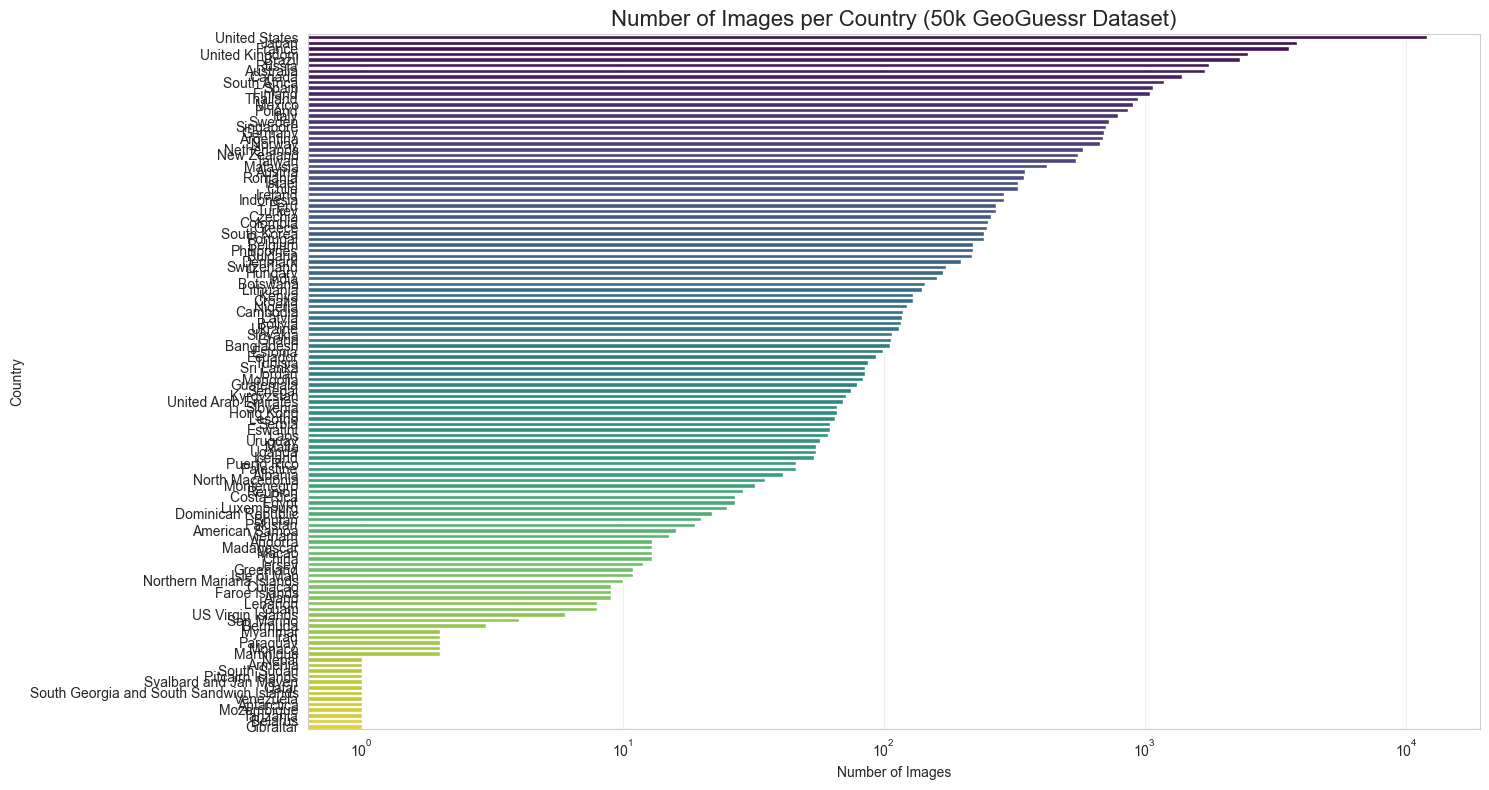

Top 10 countries
country
United States     12014
Japan              3840
France             3573
United Kingdom     2484
Brazil             2320
Russia             1761
Australia          1704
Canada             1382
South Africa       1183
Spain              1075
Name: count, dtype: int64

Bottom 10 countries
country
Pitcairn Islands                            1
Svalbard and Jan Mayen                      1
Qatar                                       1
South Georgia and South Sandwich Islands    1
Venezuela                                   1
Antarctica                                  1
Mozambique                                  1
Tanzania                                    1
Belarus                                     1
Gibraltar                                   1
Name: count, dtype: int64


In [ ]:
# class distribution 
country_counts = df['country'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(15, 8))
sns.barplot(x=country_counts.values, y=country_counts.index, palette="viridis")
plt.title("Number of Images per Country (50k GeoGuessr Dataset)", fontsize=16)
plt.xlabel("Number of Images")
plt.ylabel("Country")
plt.xscale("log")
plt.grid(True, axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig("eda_images_per_country.png", dpi=200)
plt.show()

# Top 10 & Bottom 10 table
top10 = country_counts.head(10)
bottom10 = country_counts.tail(10)

print("Top 10 countries")
print(top10)
print("\nBottom 10 countries")
print(bottom10)

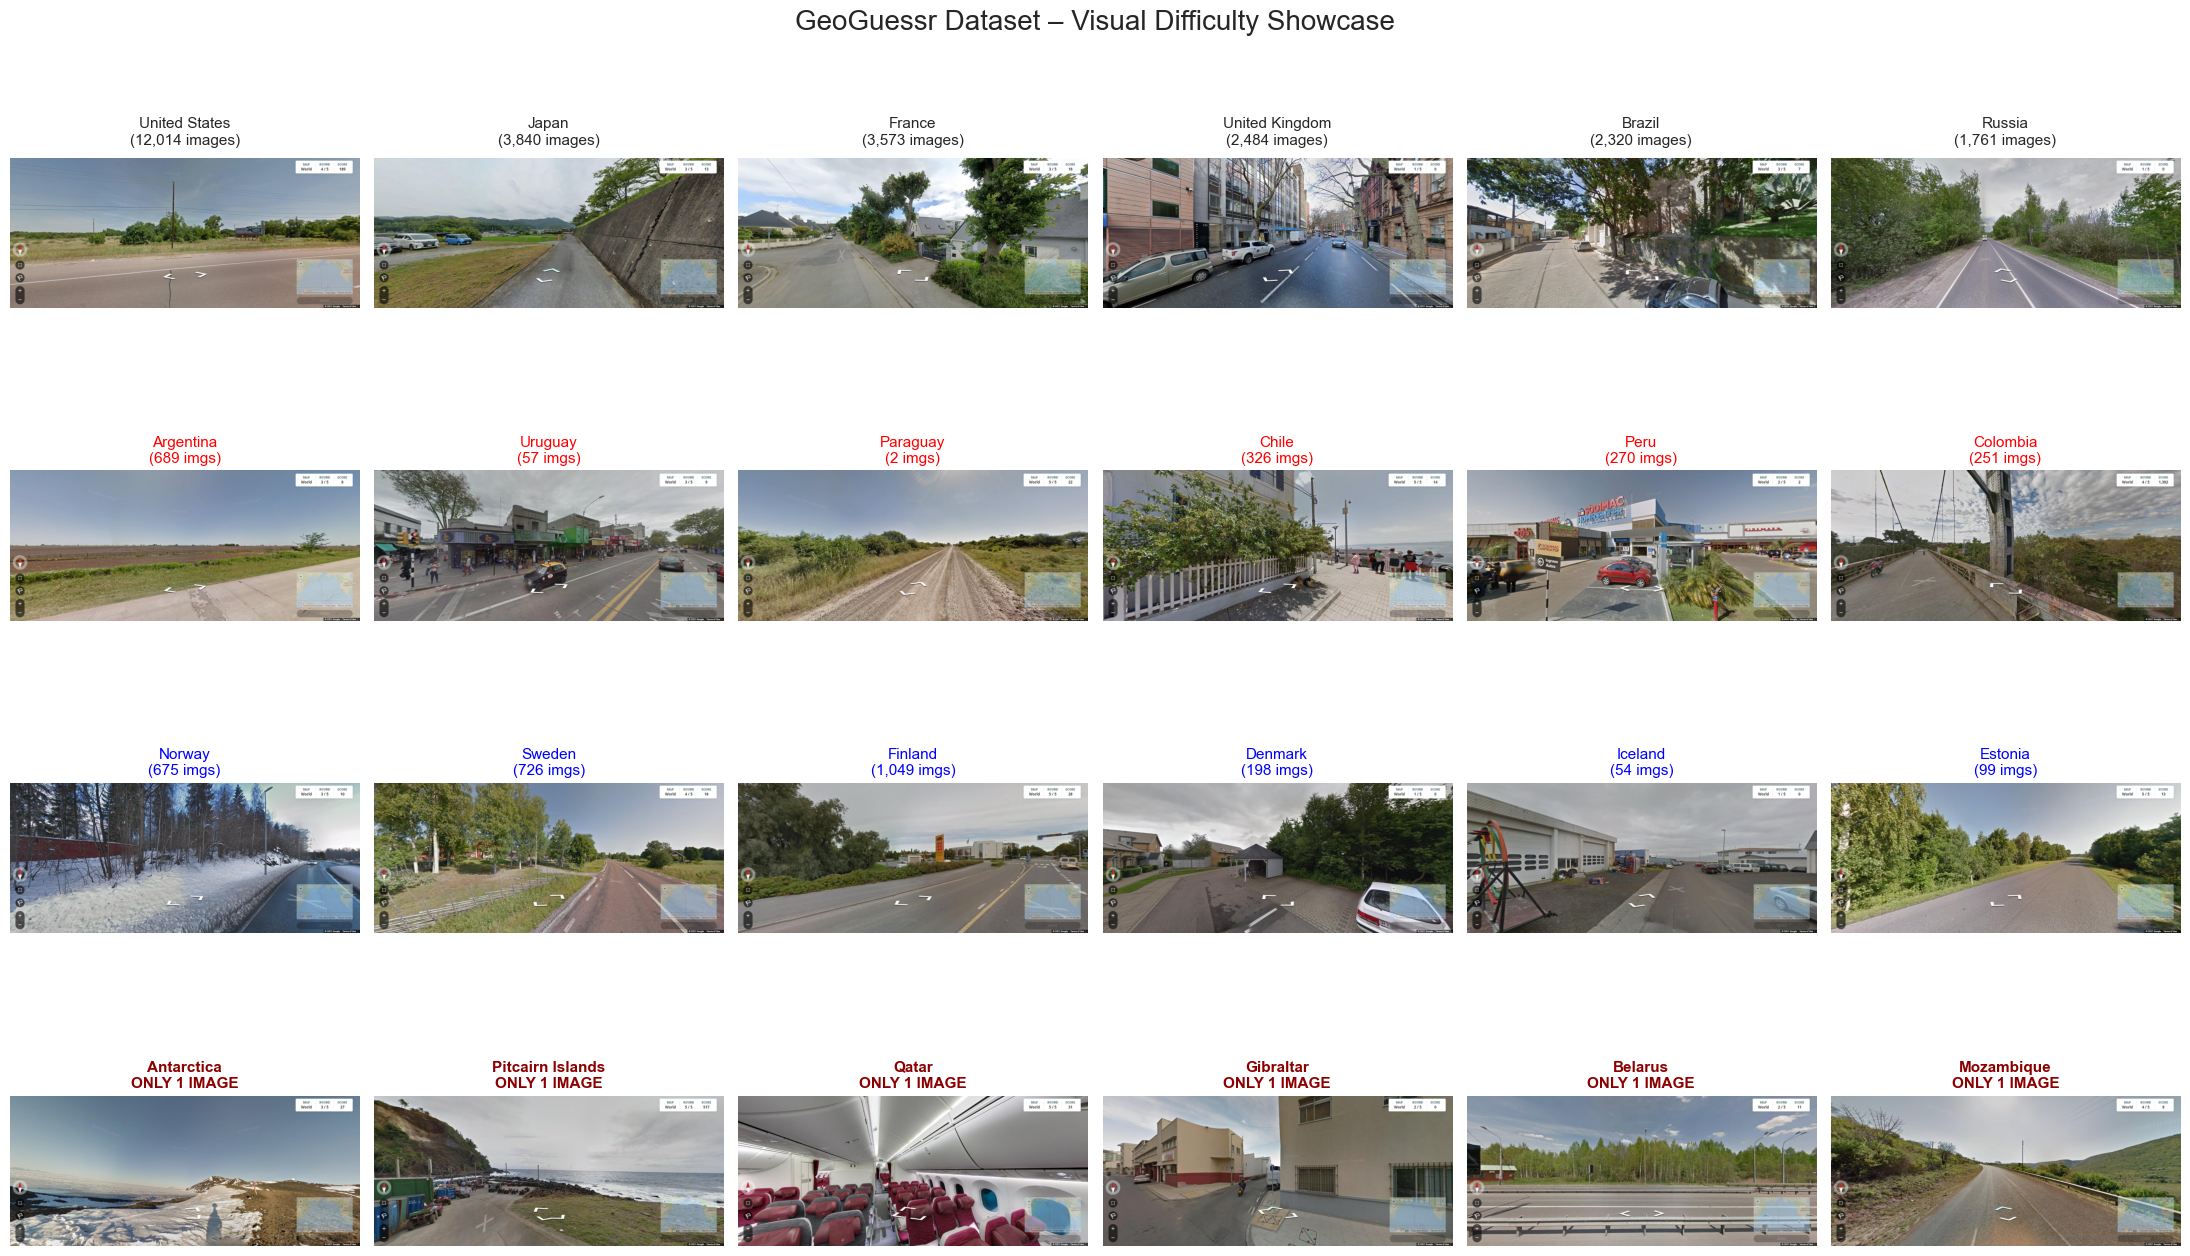

In [ ]:
# Strategic sample images
fig, axes = plt.subplots(4, 6, figsize=(22, 14))
axes = axes.ravel()
i = 0

# Row 1: The dominant giants
big_boys = ["United States", "Japan", "France", "United Kingdom", "Brazil", "Russia"]
for country in big_boys:
    sample_path = random.choice(df[df['country']==country]['path'].tolist())
    img = Image.open(sample_path)
    axes[i].imshow(img)
    axes[i].set_title(f"{country}\n({country_counts[country]:,} images)", fontsize=11, pad=10)
    axes[i].axis('off')
    i += 1

# Row 2: Medium countries that look similar
similar_looking = ["Argentina", "Uruguay", "Paraguay", "Chile", "Peru", "Colombia"]  # South America trap
for country in similar_looking:
    if country in df['country'].unique():
        sample_path = random.choice(df[df['country']==country]['path'].tolist())
        img = Image.open(sample_path)
        axes[i].imshow(img)
        axes[i].set_title(f"{country}\n({country_counts[country]:,} imgs)", fontsize=11, color="red")
        axes[i].axis('off')
    else:
        axes[i].set_title(f"{country}\n(not in dataset)", fontsize=11, color="gray")
        axes[i].axis('off')
    i += 1

# Row 3: Nordic countries
nordic = ["Norway", "Sweden", "Finland", "Denmark", "Iceland", "Estonia"]
for country in nordic:
    if country in df['country'].unique():
        sample_path = random.choice(df[df['country']==country]['path'].tolist())
        img = Image.open(sample_path)
        axes[i].imshow(img)
        axes[i].set_title(f"{country}\n({country_counts[country]:,} imgs)", fontsize=11, color="blue")
        axes[i].axis('off')
    else:
        axes[i].set_title(f"{country}\n(missing)", fontsize=11, color="gray")
        axes[i].axis('off')
    i += 1

# Row 4: Single image countries
one_shot = ["Antarctica", "Pitcairn Islands", "Qatar", "Gibraltar", "Belarus", "Mozambique"]
for country in one_shot:
    if country in df['country'].unique():
        sample_path = df[df['country']==country]['path'].iloc[0]  # only one exists
        img = Image.open(sample_path)
        axes[i].imshow(img)
        axes[i].set_title(f"{country}\nONLY 1 IMAGE", fontsize=11, color="darkred", weight="bold")
        axes[i].axis('off')
    else:
        axes[i].set_title("Empty slot", fontsize=11, color="gray")
        axes[i].axis('off')
    i += 1

# Hide remaining
while i < 24:
    axes[i].axis('off')
    i += 1

plt.suptitle("GeoGuessr Dataset – Visual Difficulty Showcase", fontsize=20, y=0.98)
plt.tight_layout()
plt.savefig("eda_critical_visual_examples.png", dpi=250, bbox_inches='tight')
plt.show()

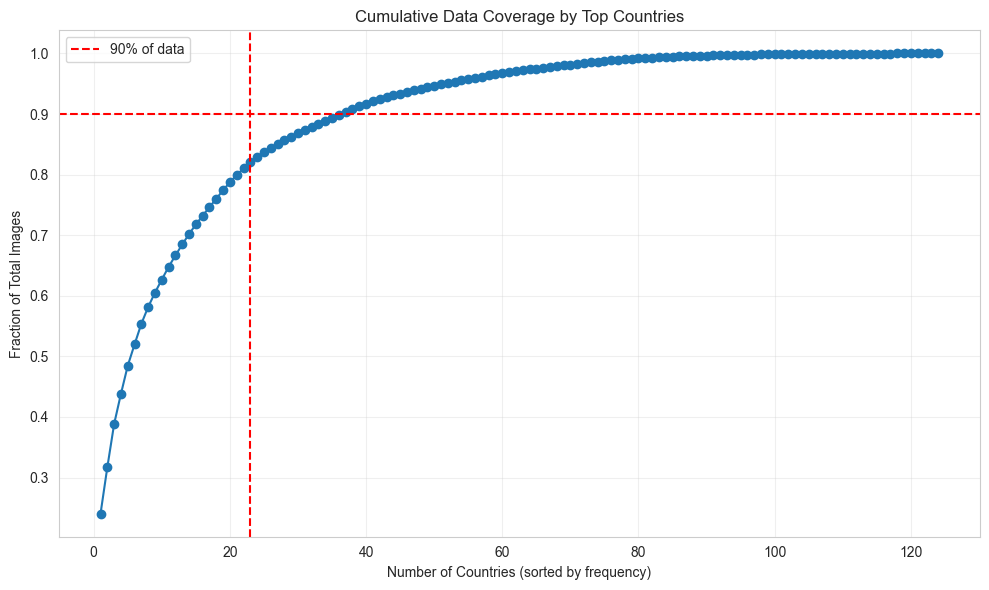

Top 37 countries = 90% of all images


In [6]:
# How many countries do you need to cover 90% of the data?
cumsum = country_counts.sort_values(ascending=False).cumsum() / country_counts.sum()
plt.figure(figsize=(10,6))
plt.plot(range(1, len(cumsum)+1), cumsum, marker='o')
plt.axhline(0.9, color='red', linestyle='--', label='90% of data')
plt.axvline(23, color='red', linestyle='--')  # you’ll see the real number
plt.title("Cumulative Data Coverage by Top Countries")
plt.xlabel("Number of Countries (sorted by frequency)")
plt.ylabel("Fraction of Total Images")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("eda_cumulative_coverage.png", dpi=200)
plt.show()

print(f"Top {np.argmax(cumsum >= 0.9) + 1} countries = 90% of all images")